In [1]:
%matplotlib inline
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
#stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

stopwords_cust = stopwords.words('portuguese')

df_swc = pd.read_excel('C:\Users\marcel.massa.LGE\ML\stop_words_customized.xlsx')
df_swc.STOP_WORDS_CUSTOMIZED=df_swc.STOP_WORDS_CUSTOMIZED.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.lower()
for count in range (df_swc.shape[0]):
    stopwords_cust.append(df_swc.STOP_WORDS_CUSTOMIZED[count])

In [2]:
df = pd.read_excel('C:\\Users\\marcel.massa.LGE\\ML\\train_multilabel.xlsx')

In [ ]:
df.head()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1979 entries, 0 to 1978
Data columns (total 28 columns):
Claim                                                  1979 non-null object
Account                                                1979 non-null int64
Application                                            1979 non-null int64
Audio / Earphones / Speaker                            1979 non-null int64
No Power / Auto Power-off                              1979 non-null int64
Battery / No charging / Fast discharge                 1979 non-null int64
Bluetooth                                              1979 non-null int64
Calls (drop / audio quality)                           1979 non-null int64
Camera                                                 1979 non-null int64
Features (Settings / Contacts / Keyborad / Message)    1979 non-null int64
Network (signal / data connection)                     1979 non-null int64
Fingerprint sensor                                     1979 non-nul

In [5]:
#Number of comments in each category

df_symptoms = df.drop(['Claim'], axis=1)
counts = []
categories = list(df_symptoms.columns.values)
for i in categories:
    counts.append((i, df_symptoms[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_claims'])
df_stats

,category,number_of_claims
0,Account,96
1,Application,86
2,Audio / Earphones / Speaker,103
3,No Power / Auto Power-off,328
4,Battery / No charging / Fast discharge,392
5,Bluetooth,13
6,Calls (drop / audio quality),61
7,Camera,35
8,Features (Settings / Contacts / Keyborad / Mes...,68
9,Network (signal / data connection),44


Text(0.5,0,'category')

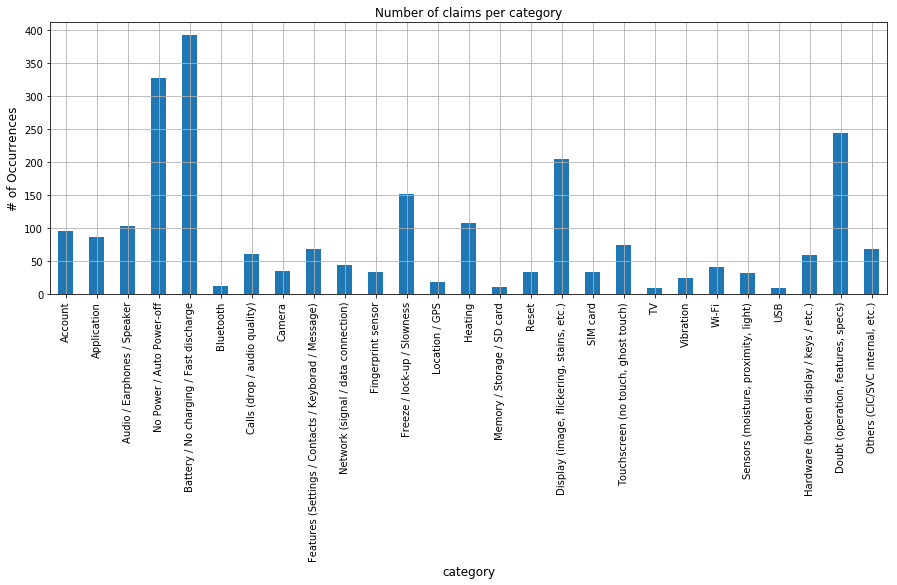

In [6]:
df_stats.plot(x='category', y='number_of_claims', kind='bar', legend=False, grid=True, figsize=(15, 5))
plt.title("Number of claims per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

Text(0,0.5,'# of Occurrences')

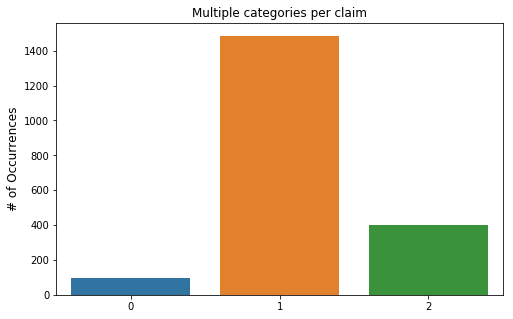

In [7]:
#Multi-Label
#How many comments have multiple labels?

rowsums = df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per claim")
plt.ylabel('# of Occurrences', fontsize=12)
#plt.xlabel('# of categories', fontsize=12)

Vast majority of the comment texts are not labeled.
The distribution of the number of words in comment texts.


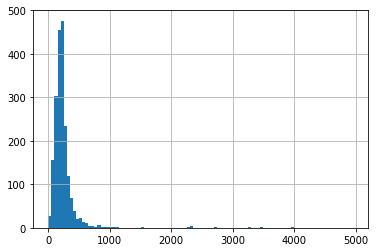

In [8]:
lens = df.Claim.str.len()
lens.hist(bins = np.arange(0,5000,50))

Most of the comment text length are within 500 characters, with some outliers up to 5,000 characters long.


In [10]:
print('Percentage of claims that are not labelled:')
print(len(df[(df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']== 0) & (df['insult']==0) & (df['identity_hate']==0)]) / len(df))

Percentage of comments that are not labelled:
0


There is no missing comment in comment text column.

In [13]:
print('Number of missing claims in Claims:')
df['Claim'].isnull().sum()

Number of missing claims in Claims:


0

Have a peek the first comment, the text needs clean.

In [ ]:
df['Claim'][0]

In [10]:
#categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
categories

['Account',
 'Application',
 'Audio / Earphones / Speaker',
 'No Power / Auto Power-off',
 'Battery / No charging / Fast discharge',
 'Bluetooth',
 'Calls (drop / audio quality)',
 'Camera',
 'Features (Settings / Contacts / Keyborad / Message)',
 'Network (signal / data connection)',
 'Fingerprint sensor',
 'Freeze / lock-up / Slowness',
 'Location / GPS',
 'Heating',
 'Memory / Storage / SD card',
 'Reset',
 'Display (image, flickering, stains, etc.)',
 'SIM card',
 'Touchscreen (no touch, ghost touch)',
 'TV',
 'Vibration',
 'Wi-Fi',
 'Sensors (moisture, proximity, light)',
 'USB',
 'Hardware (broken display / keys / etc.)',
 'Doubt (operation, features, specs)',
 'Others (CIC/SVC internal, etc.)']

Create a function to clean the text

In [14]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='utf-8', ngram_range=(1, 2), lowercase=True, stop_words=stopwords_cust, strip_accents='unicode')

features = tfidf.fit_transform(df.Texto).toarray()
labels = df.category_id
features.shape

Clean up comment_text column

In [15]:
df['comment_text'] = df['comment_text'].map(lambda com : clean_text(com))

In [16]:
df['comment_text'][0]

u'explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now 89 205 38 27'

Split to train and test sets

In [11]:
train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)

In [12]:
X_train = train.Claim
X_test = test.Claim
print(X_train.shape)
print(X_test.shape)

(1325,)
(654,)


Pipeline
scikit-learn provides a Pipeline utility to help automate machine learning workflows. Pipelines are very common in Machine Learning systems, since there is a lot of data to manipulate and many data transformations to apply. So we will utilize pipeline to train every classifier.

OneVsRest multilabel strategy
The Multi-label algorithm accepts a binary mask over multiple labels. The result for each prediction will be an array of 0s and 1s marking which class labels apply to each row input sample.

Naive Bayes
OneVsRest strategy can be used for multilabel learning, where a classifier is used to predict multiple labels for instance. Naive Bayes supports multi-class, but we are in a multi-label scenario, therefore, we wrapp Naive Bayes in the OneVsRestClassifier.


In [19]:
# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

In [20]:
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing toxic
Test accuracy is 0.919576900435
... Processing severe_toxic
Test accuracy is 0.990011204163
... Processing obscene
Test accuracy is 0.95165118973
... Processing threat
Test accuracy is 0.997113503864
... Processing insult
Test accuracy is 0.951784120473
... Processing identity_hate
Test accuracy is 0.991055660001


In [18]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='utf-8', analyzer='word', ngram_range=(1, 2), lowercase=True, stop_words=stopwords_cust, strip_accents='unicode')),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])

In [21]:
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing Account
Test accuracy is 0.966360856269
... Processing Application
Test accuracy is 0.95871559633
... Processing Audio / Earphones / Speaker
Test accuracy is 0.957186544343
... Processing No Power / Auto Power-off
Test accuracy is 0.922018348624
... Processing Battery / No charging / Fast discharge
Test accuracy is 0.937308868502
... Processing Bluetooth
Test accuracy is 0.989296636086
... Processing Calls (drop / audio quality)
Test accuracy is 0.980122324159
... Processing Camera
Test accuracy is 0.992354740061
... Processing Features (Settings / Contacts / Keyborad / Message)
Test accuracy is 0.967889908257
... Processing Network (signal / data connection)
Test accuracy is 0.987767584098
... Processing Fingerprint sensor
Test accuracy is 0.983180428135
... Processing Freeze / lock-up / Slowness
Test accuracy is 0.95871559633
... Processing Location / GPS
Test accuracy is 0.990825688073
... Processing Heating
Test accuracy is 0.957186544343
... Processing Memory / Stor

In [23]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing toxic
Test accuracy is 0.954917487989
... Processing severe_toxic
Test accuracy is 0.991055660001
... Processing obscene
Test accuracy is 0.976091456351
... Processing threat
Test accuracy is 0.997360375244
... Processing insult
Test accuracy is 0.968742285269
... Processing identity_hate
Test accuracy is 0.991758293929


In [ ]:
df_new = pd.read_excel('C:\Users\marcel.massa.LGE\ML\CIC Call Receiving Rate.xls')
df_new.head()

In [15]:
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(df.Claim, df[category])
    # compute the testing accuracy
    prediction_new = SVC_pipeline.predict(df_new.loc[: ,"Consultation Content"])
    # print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    df_new[category] = prediction_new

... Processing Account
... Processing Application
... Processing Audio / Earphones / Speaker
... Processing No Power / Auto Power-off
... Processing Battery / No charging / Fast discharge
... Processing Bluetooth
... Processing Calls (drop / audio quality)
... Processing Camera
... Processing Features (Settings / Contacts / Keyborad / Message)
... Processing Network (signal / data connection)
... Processing Fingerprint sensor
... Processing Freeze / lock-up / Slowness
... Processing Location / GPS
... Processing Heating
... Processing Memory / Storage / SD card
... Processing Reset
... Processing Display (image, flickering, stains, etc.)
... Processing SIM card
... Processing Touchscreen (no touch, ghost touch)
... Processing TV
... Processing Vibration
... Processing Wi-Fi
... Processing Sensors (moisture, proximity, light)
... Processing USB
... Processing Hardware (broken display / keys / etc.)
... Processing Doubt (operation, features, specs)
... Processing Others (CIC/SVC internal

In [ ]:
df_new.head()

In [17]:
df_new.to_excel('C:\Users\marcel.massa.LGE\ML\CIC Call Receiving Rate_MULTI_LABEL_PREDICTED.xlsx')